# Natural Language Processing with Disaster Tweets

In the era of social media, platforms like Twitter have become crucial channels for real-time communication, especially during emergencies and disasters. The challenge lies in distinguishing between tweets that convey actual disaster-related information and those that do not, particularly given the nuances of human language, such as sarcasm, metaphors, and varied expressions.

This project aims to develop a machine learning model capable of predicting whether a tweet is about a real disaster or not. To achieve this, a dataset comprising 10,000 tweets, each hand-classified as either disaster-related or not, is available for training the model.

However, before feeding the text data into a machine learning model, it is essential to preprocess the text. Text data, by nature, is unstructured and requires conversion into a structured format that machine learning models can interpret. This involves several steps:
- **Tokenization**: Breaking down the text into individual words or tokens.
- **Vectorization**: Converting these tokens into numerical representations, such as word embeddings or TF-IDF vectors.
- **Normalization**: Standardizing the text by converting it to lowercase, removing punctuation, and possibly stemming or lemmatizing words.
- **Feature Selection**: Identifying and retaining the most relevant features that contribute to the model’s predictive power.

Once the text data is preprocessed and transformed into a suitable format, it becomes part of the natural language processing (NLP) workflow. This workflow involves training a machine learning model on the processed data, optimizing the model’s performance, and making predictions on unseen data.

Through this project, we will explore various preprocessing techniques, model selection strategies, and evaluation methods to build an effective model that can accurately identify disaster-related tweets, contributing to timely and effective disaster response efforts.

# Import Library

In [1]:
import numpy as np  # Numerical computations and linear algebra
import pandas as pd  # Data processing and manipulation, especially for handling CSV files
import tensorflow as tf  # Deep learning framework for building and training models
import keras_core as keras  # Core Keras library for creating neural networks
import keras_nlp  # Keras NLP tools for natural language processing tasks
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix  # Metrics for model evaluation
import seaborn as sns  # Data visualization library, particularly for heatmaps and plots
import matplotlib.pyplot as plt  # General plotting library for creating visualizations

# Print versions of the key libraries
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
KerasNLP version: 0.14.4


# Load Dataset : Disaster Tweets

### About the Dataset

The dataset used in this project consists of two primary files:

- **`train_data`:** This file contains the labeled data used for training the model. Each row represents a tweet with its corresponding metadata, including a unique identifier (`id`), the tweet text (`text`), an optional location (`location`), an optional keyword (`keyword`), and the target label (`target`) indicating whether the tweet is about a real disaster (1) or not (0).

- **`test_data`:** This file contains the unlabeled data that will be used to evaluate the model's performance. It has the same structure as the training data but without the `target` column.

By loading these datasets into `train_data` and `test_data`, we prepare the data for further preprocessing and model training. This step is crucial as it sets the foundation for the entire machine learning workflow.

In [2]:
# Load the training and test datasets using pandas
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

# Explore the dataset + Exploratory Data Analysis (EDA)

* **Data Shape & Types:** Ensures you understand the structure and format of both datasets.
* **Sample Data:** Provides a quick overview of the data's content and helps you identify any anomalies.
* **Missing Values:** Identifying missing data in both datasets is crucial for consistent preprocessing.
* **Class Distribution:** Helps you determine if there’s a need for class imbalance strategies in the training data.
* **Keyword & Location Analysis:** Offers additional context that might enhance model performance by providing insights into recurring patterns.
* **Text Data Examination:** Helps guide your text preprocessing strategy by revealing characteristics of the tweet content.

In [3]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (7613, 5)
Test data shape: (3263, 4)


In [4]:
print("Training data types:\n", train_data.dtypes)
print("\nTest data types:\n", test_data.dtypes)

Training data types:
 id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Test data types:
 id           int64
keyword     object
location    object
text        object
dtype: object


In [5]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print("Missing values in training data:\n", train_data.isnull().sum())
print("\nMissing values in test data:\n", test_data.isnull().sum())

Missing values in training data:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
 id             0
keyword       26
location    1105
text           0
dtype: int64


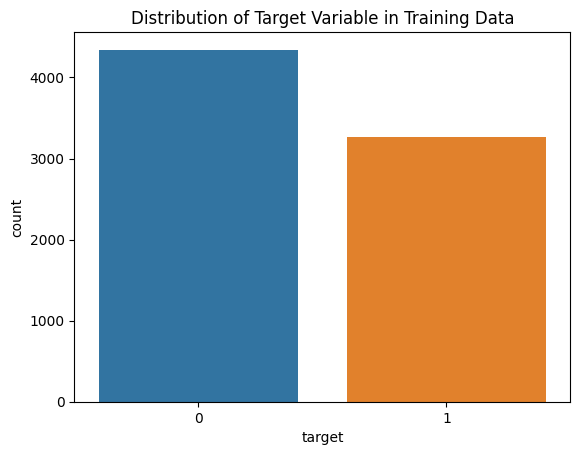

In [8]:
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable in Training Data')
plt.show()

In [9]:
print("Most common keywords in training data:", train_data['keyword'].value_counts().head(10))
print("Most common locations in training data:", train_data['location'].value_counts().head(10))

print("\nMost common keywords in test data:", test_data['keyword'].value_counts().head(10))
print("Most common locations in test data:", test_data['location'].value_counts().head(10))

Most common keywords in training data: keyword
fatalities     45
armageddon     42
deluge         42
harm           41
damage         41
sinking        41
body%20bags    41
siren          40
windstorm      40
twister        40
Name: count, dtype: int64
Most common locations in training data: location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64

Most common keywords in test data: keyword
deluged               23
rubble                22
demolished            22
obliteration          21
annihilation          21
first%20responders    21
seismic               21
snowstorm             21
sirens                21
survivors             20
Name: count, dtype: int64
Most common locations in test data: location
New York          38
USA               37
Worldwide         16
United States 

Train Length Statistics
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Statistics
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64



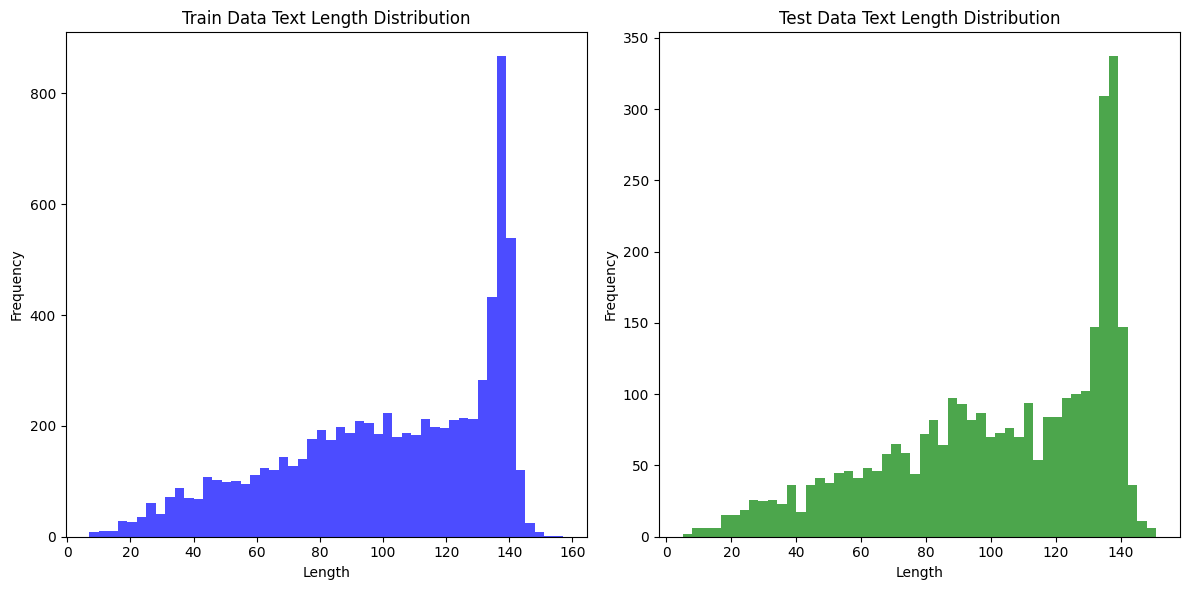

In [10]:
# Add a length column to both DataFrames
train_data["length"] = train_data["text"].apply(lambda x: len(x) if pd.notnull(x) else 0)
test_data["length"] = test_data["text"].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Print statistical summary for train and test datasets
print("Train Length Statistics")
print(train_data["length"].describe())
print()

print("Test Length Statistics")
print(test_data["length"].describe())
print()

# Optional: Visualization of the text length distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_data["length"], bins=50, color='blue', alpha=0.7)
plt.title('Train Data Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_data["length"], bins=50, color='green', alpha=0.7)
plt.title('Test Data Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

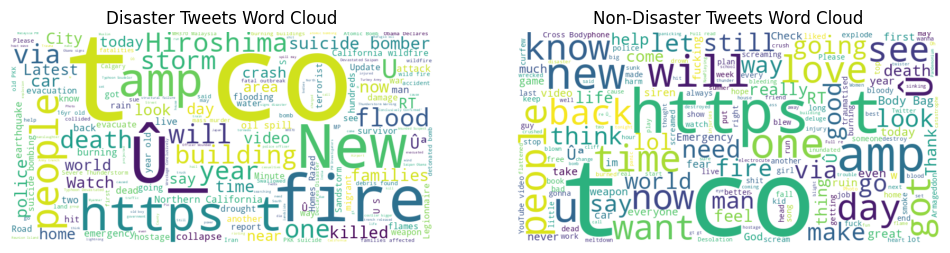

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for disaster tweets
disaster_tweets = train_data[train_data['target'] == 1]['text']
disaster_text = ' '.join(disaster_tweets)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)

# Generate word cloud for non-disaster tweets
non_disaster_tweets = train_data[train_data['target'] == 0]['text']
non_disaster_text = ' '.join(non_disaster_tweets)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets Word Cloud')
plt.axis('off')

plt.show()

# Data Preprocessing

**Handling Missing Values in the Dataset**

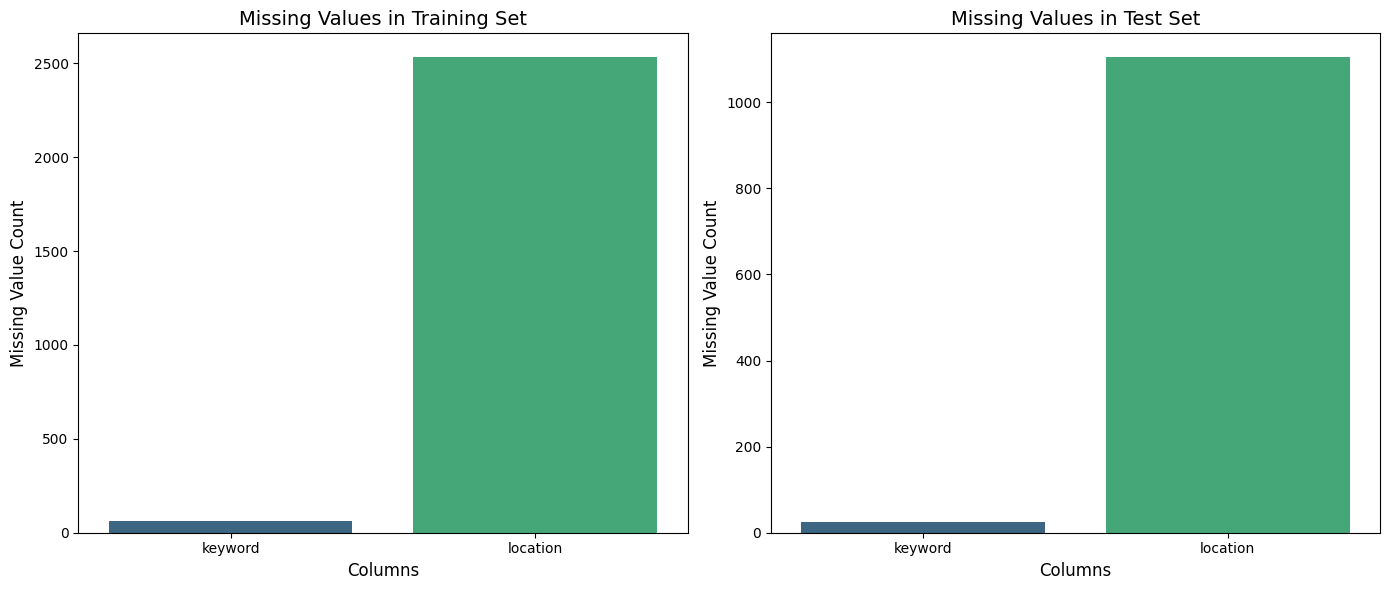

In [12]:
# Define columns with missing values
missing_cols = ['keyword', 'location']

# Create subplots to visualize missing values in training and test datasets
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), dpi=100)

# Plot missing values for training data
sns.barplot(x=train_data[missing_cols].isnull().sum().index, 
            y=train_data[missing_cols].isnull().sum().values, 
            ax=axes[0],
            palette='viridis')
axes[0].set_ylabel('Missing Value Count', size=12)
axes[0].set_xlabel('Columns', size=12)
axes[0].set_title('Missing Values in Training Set', fontsize=14)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Plot missing values for test data
sns.barplot(x=test_data[missing_cols].isnull().sum().index, 
            y=test_data[missing_cols].isnull().sum().values, 
            ax=axes[1],
            palette='viridis')
axes[1].set_ylabel('Missing Value Count', size=12)
axes[1].set_xlabel('Columns', size=12)
axes[1].set_title('Missing Values in Test Set', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

#### Missing Values Ratio

Both the training and test datasets exhibit similar patterns regarding missing values:

- **Keyword Column:**
  - Approximately 0.8% of the `keyword` entries are missing in both the training and test datasets.

- **Location Column:**
  - Around 33% of the `location` entries are missing in both datasets.

The close similarity in the ratio of missing values between the training and test sets suggests that these datasets were likely sampled from the same source. This consistent pattern indicates that the missing values are not random but are systematically missing across both datasets.

#### Handling Missing Values

Given the uniformity in missing values between the datasets, it is appropriate to apply the same strategy for handling these missing values in both cases. 

**Replacement Strategy:**

- **For `keyword` Column:** 
  - Fill missing values with the placeholder `'no_keyword'`. This placeholder will indicate that no specific keyword was available for those entries.

- **For `location` Column:** 
  - Replace missing values with `'no_location'`. This signifies that the location data was not provided or is unavailable.

**Pre-processing text**

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize objects
stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
tokenizer = Tokenizer(num_words=20000, lower=True)

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop])
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text

# Apply preprocessing to train and test data
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

# Fit tokenizer on the processed text
tokenizer.fit_on_texts(train_data['text'].values)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'].values)
test_sequences = tokenizer.texts_to_sequences(test_data['text'].values)

# Pad sequences
max_len = 100
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Display shapes of padded sequences
print(f"Training data shape: {train_padded.shape}")
print(f"Test data shape: {test_padded.shape}")

Training data shape: (7613, 100)
Test data shape: (3263, 100)


In [15]:
!pip install transformers tensorflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Model 1

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_data['target'].values, test_size=0.2, random_state=42)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional

# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
96/96 - 29s - 302ms/step - accuracy: 0.6824 - loss: 0.5938 - val_accuracy: 0.8076 - val_loss: 0.4398
Epoch 2/5
96/96 - 22s - 227ms/step - accuracy: 0.8530 - loss: 0.3493 - val_accuracy: 0.7840 - val_loss: 0.4788
Epoch 3/5
96/96 - 22s - 225ms/step - accuracy: 0.9118 - loss: 0.2311 - val_accuracy: 0.7748 - val_loss: 0.5359
Epoch 4/5
96/96 - 22s - 225ms/step - accuracy: 0.9491 - loss: 0.1473 - val_accuracy: 0.7538 - val_loss: 0.6439
Epoch 5/5
96/96 - 22s - 226ms/step - accuracy: 0.9660 - loss: 0.1063 - val_accuracy: 0.7387 - val_loss: 0.7053


In [19]:

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Loss: 0.7052707076072693
Validation Accuracy: 0.7386736869812012


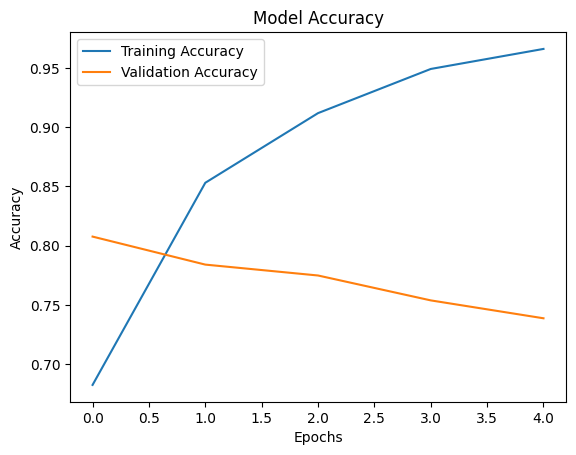

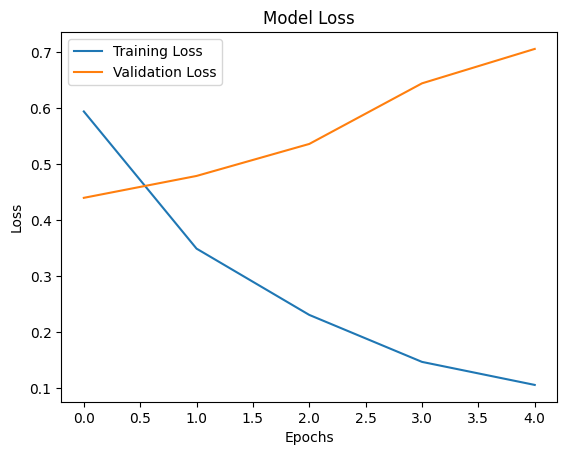

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate the submission file

In [21]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [22]:
# Make predictions on the test data
test_predictions = model.predict(test_padded)
test_predictions = (test_predictions > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


In [23]:
sample_submission.describe()

,id,target
count,3263.000000,3263.0
mean,5427.152927,0.0
std,3146.427221,0.0
min,0.000000,0.0
25%,2683.000000,0.0
50%,5500.000000,0.0
75%,8176.000000,0.0
max,10875.000000,0.0


In [24]:
# Prepare the Submission File
submission = sample_submission.copy()
submission['target'] = test_predictions

In [25]:
# Check the first few rows of the submission file
print(submission.head())

# Save the file
submission.to_csv('/kaggle/working/submission_a4.csv', index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


# Model 2

In [26]:
Train_dataset='/kaggle/input/nlp-getting-started/train.csv'
Test_dataset='/kaggle/input/nlp-getting-started/test.csv'

In [27]:
Test=pd.read_csv(Test_dataset)
test_shape=Test.shape
Train=pd.read_csv(Train_dataset)
train_shape=Train.shape

In [28]:
test_num_rows = test_shape[0]
train_num_rows = train_shape[0]

In [29]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

main_ds = tf.data.experimental.make_csv_dataset(
    Train_dataset,
    select_columns=['text','target'],
    label_name='target',
    batch_size=BATCH_SIZE,
    num_epochs=1, # Ensure go through the data once to create a finite dataset
    shuffle=True,
    shuffle_buffer_size=BUFFER_SIZE,
    prefetch_buffer_size=tf.data.AUTOTUNE,
    num_rows_for_inference=train_num_rows # Help tf optimize the dataset creation
)

# Spilt the main dataset to train & validation datasets
num_val_elements = int(train_num_rows * VALIDATION_SPLIT // BATCH_SIZE)
raw_val_ds = main_ds.take(num_val_elements)
raw_train_ds = main_ds.skip(num_val_elements)

In [30]:
raw_train_ds.element_spec

(OrderedDict([('text',
               TensorSpec(shape=(None,), dtype=tf.string, name=None))]),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [31]:
for batch, label in raw_train_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value[:3]}")
    print()
    print(f"{'label':20s}: {label[:3]}")

text                : [b'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/x2Wn7O2a3w via @Change'
 b'the fall of leaves from a poplar is as fully ordained as the tumbling of an avalanche - Spurgeon'
 b'@JagexHelpDibi update JAG enabled but a hijacker has access might be what I was looking for. Fingers crossed.']

label               : [0 0 0]


In [32]:
def dict_to_text(dict, label):
  return dict['text'], label

train_ds = raw_train_ds.map(dict_to_text)
val_ds = raw_val_ds.map(dict_to_text)

In [33]:
from tensorflow.keras import layers

MAX_FEATURES = 10000
SEQUENCE_LENGTH = 160

vectorizer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

In [34]:
# Make text-only dataset before adapt
text_ds = train_ds.map(lambda text, label:text)
vectorizer.adapt(text_ds)

In [35]:
vocabulary = np.array(vectorizer.get_vocabulary())
vocabulary[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'with', 'it', 'that', 'at', 'by', 'this'],
      dtype='<U49')

In [36]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorizer(text), label

In [37]:
# retrieve a batch (of 64 texts and labels) from the dataset
texts, labels = next(iter(train_ds))
text1, label1 = texts[0], labels[0]
vectorized_text, label = vectorize_text(text1, label1)
print("Original tweet: ", text1.numpy())
print("Label: ", label1.numpy())
print("Vectorized tweet: ", vectorized_text.numpy())
print("Round-trip tweet: ", " ".join(vocabulary[vectorized_text.numpy()[0]]))

Original tweet:  b'16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/5orTB8p51c'
Label:  1
Vectorized tweet:  [[746 226 685  87 196  65 655 114   4 709 187 898 418   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Round-trip tweet:  16yr old pkk suicide bomber who detonated bomb in turkey army trench released [UNK]                                                                                        

In [38]:
model = tf.keras.Sequential([
    vectorizer,
    layers.Embedding(
        input_dim=len(vectorizer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [41]:
EPOCHS = 10
rnn_history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/10
     93/Unknown 6s 14ms/step - accuracy: 0.5648 - loss: 0.6921

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5649 - loss: 0.6920 - val_accuracy: 0.5849 - val_loss: 0.6824
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5803 - loss: 0.6746 - val_accuracy: 0.5795 - val_loss: 0.6051
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6384 - loss: 0.5689 - val_accuracy: 0.8166 - val_loss: 0.4345
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8215 - loss: 0.4236 - val_accuracy: 0.8533 - val_loss: 0.3687
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8687 - loss: 0.3508 - val_accuracy: 0.8913 - val_loss: 0.2800
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8808 - loss: 0.3146 - val_accuracy: 0.8906 - val_loss: 0.2743
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9040 - loss: 0.2610 - val_accuracy: 0.9212 - val_loss: 0.2192
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9229 - loss: 0.2238 - val_accuracy: 0.9232 - val_loss: 0.

In [42]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=SEQUENCE_LENGTH,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics= ["accuracy"]
)

In [44]:
nlp_history = classifier.fit(train_ds,
                         epochs=10, 
                         validation_data=val_ds)

Epoch 1/10


I0000 00:00:1725104450.359246      88 service.cc:145] XLA service 0x7b75ac7bff90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725104450.359339      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725104495.956359      88 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 116 bytes spill stores, 152 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 72 bytes spill stores, 104 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1725104496.013202      88 device_compiler.h:188] Compiled 

     95/Unknown 103s 406ms/step - accuracy: 0.7582 - loss: 0.4964

I0000 00:00:1725104579.183207      88 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 116 bytes spill stores, 152 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 72 bytes spill stores, 104 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 12 bytes spill stores, 12 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 941ms/step - accuracy: 0.7591 - loss: 0.4954 - val_accuracy: 0.8777 - val_loss: 0.3101
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.8714 - loss: 0.3233 - val_accuracy: 0.9090 - val_loss: 0.2362
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.9017 - loss: 0.2560 - val_accuracy: 0.9511 - val_loss: 0.1760
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.9623 - loss: 0.1126 - val_accuracy: 0.9674 - val_loss: 0.1135
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.9676 - loss: 0.0943 - val_accuracy: 0.9755 - val_loss: 0.0573
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.9712 - loss: 0.0784 - val_accuracy: 0.9857 - val_loss: 0.0442
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.9788 - loss: 0.0610 - val_accuracy: 0.9688 - val_loss: 0.0689
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.9759 - loss: 0.0610 - val_accuracy: 0.9

In [45]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9221 - loss: 0.1690
Loss:  0.17025113105773926
Accuracy:  0.93138587474823


In [46]:
rnn_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

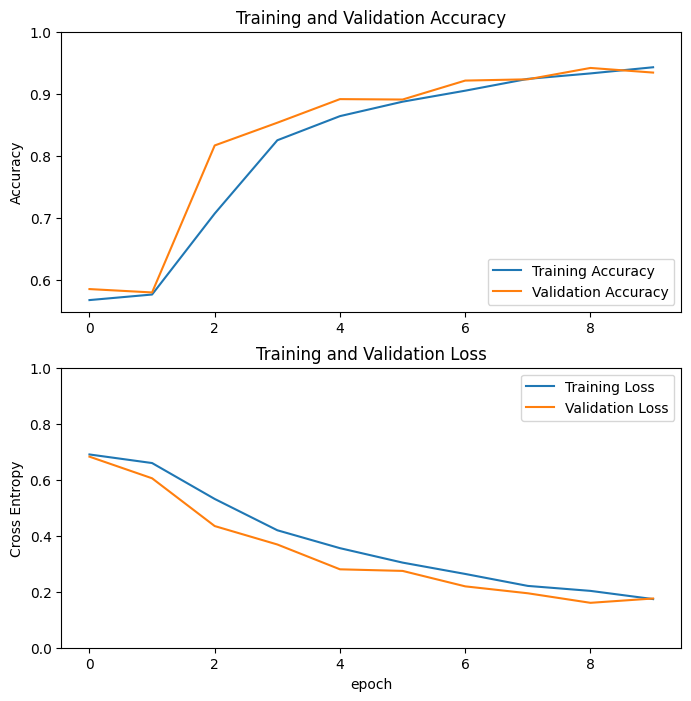

In [47]:
def preview_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

preview_learning_curve(rnn_history)

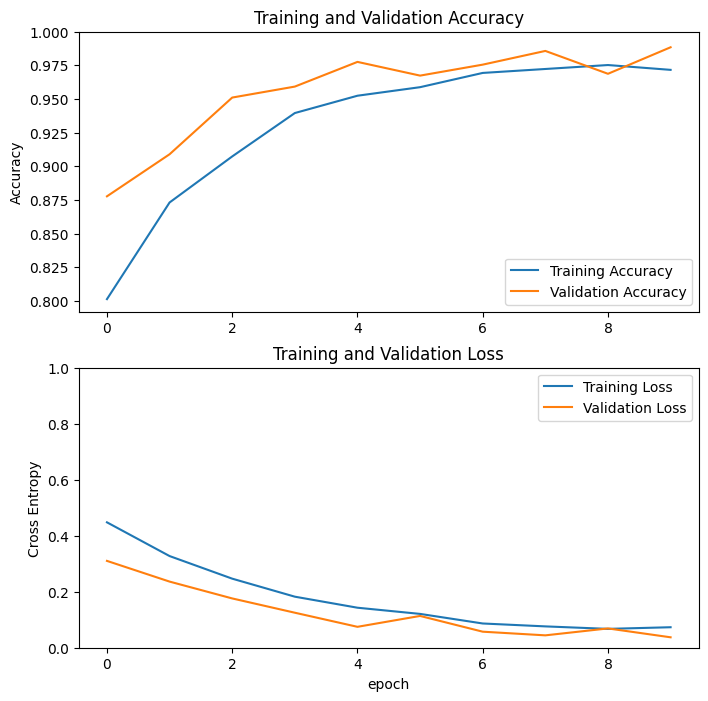

In [48]:
preview_learning_curve(nlp_history)